# Regression analysis
In statistical modeling, regression analysis is a set of statistical processes for estimating the relationships between a dependent variable (often called the 'outcome' or 'response' variable) and one or more independent variables (often called 'predictors', 'covariates', 'explanatory variables' or 'features'). The most common form of regression analysis is linear regression, in which one finds the line (or a more complex linear combination) that most closely fits the data according to a specific mathematical criterion. For example, the method of ordinary least squares computes the unique line (or hyperplane) that minimizes the sum of squared differences between the true data and that line (or hyperplane). For specific mathematical reasons (see linear regression), this allows the researcher to estimate the conditional expectation (or population average value) of the dependent variable when the independent variables take on a given set of values. Less common forms of regression use slightly different procedures to estimate alternative location parameters (e.g., quantile regression or Necessary Condition Analysis) or estimate the conditional expectation across a broader collection of non-linear models (e.g., nonparametric regression).

In [2]:
#importing the required modules
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

# ttest and euclidean distance
from scipy.stats import ttest_ind
from scipy.spatial.distance import seuclidean

# linear fit using statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# good ole sklearn
from sklearn.metrics import euclidean_distances, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                           accuracy_score)

Loading the data

In [2]:


# Small adjustments to default style of plots, making sure it's readable and colorblind-friendly everywhere
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size' : 12.5,
                     'figure.figsize':(14,5)})

#copy the path of the sample quotes: (to big to put in the git)
#ALEX: 'C:/Users/alexb/Documents/Ecole/EPFL/MasterII/ADA/'
#JULES: ...
#MARIN: ...
#NICO: ...


path_2_data = 'C:/Users/alexb/Documents/Ecole/EPFL/MasterII/ADA/'


#import the dataset sample
df = pd.read_json(path_2_data + 'df_quotes_pol_all_classified.json.bz2',compression="bz2",lines=True)


Here are the available columns for the different regression analysis

In [3]:
df.columns


Index(['quoteID', 'quotation', 'speaker', 'qid_unique', 'date', 'urls', 'p1',
       'p2', 'delta_p', 'year', 'label', 'aliases', 'date_of_birth',
       'nationality', 'gender', 'lastrevid', 'ethnic_group',
       'US_congress_bio_ID', 'occupation', 'party', 'academic_degree', 'id',
       'candidacy', 'type', 'religion', 'age', 'bi_party',
       'colloquial_NaiveBayes', 'colloquial_contractions'],
      dtype='object')

Quick look at some value inside the dataframe

In [4]:
df.sample(5)

,quoteID,quotation,speaker,qid_unique,date,urls,p1,p2,delta_p,year,...,party,academic_degree,id,candidacy,type,religion,age,bi_party,colloquial_NaiveBayes,colloquial_contractions
110053,2016-02-16-079507,One of my favorite political ads of all time w...,Hillary Clinton,Q6294,2016-02-16 19:15:00,[http://feeds.people.com/~r/people/headlines/~...,0.8013,0.1987,0.6026,2016,...,"[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,"[Q699872, Q4791768]",item,[Q33203],74.0,Republican,formal,0
211682,2017-12-30-046535,The Knights of Columbus is happy to partner wi...,Carl Anderson,Q19864204,2017-12-30 00:52:13,[http://mysanantonio.com/news/article/New-Have...,0.9057,0.0902,0.8155,2017,...,[Q29552],None,Q19864204,None,item,None,60.0,Democrat,formal,0
334731,2018-01-15-023077,He said the Negro cannot win if he is willing ...,Alveda King,Q4737931,2018-01-15 13:44:39,[http://www.lifenews.com/2018/01/15/martin-lut...,0.7966,0.2034,0.5932,2018,...,"[Q29468, Q29552]",None,Q4737931,None,item,[Q93191],70.0,Republican,formal,0
9986,2015-05-06-009132,Even the guy that wrote the book apparently ha...,Hillary Clinton,Q6294,2015-05-06 20:12:32,[http://www.ijreview.com/2015/05/314375-bill-c...,0.5762,0.1214,0.4548,2015,...,"[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,"[Q699872, Q4791768]",item,[Q33203],74.0,Republican,informal,1
123663,2016-02-16-015169,But what is also true is Justice Alito is on t...,President Barack Obama,Q76,2016-02-16 20:02:00,[http://www.cnbc.com/2016/02/16/reuters-americ...,0.6258,0.2364,0.3894,2016,...,[Q29552],"[Q1765120, Q1540185]",Q76,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]",60.0,Democrat,informal,0


In [5]:
df_reg = df[['bi_party','gender','age','colloquial_NaiveBayes', 'colloquial_contractions']]

In [6]:
df_reg = df_reg.replace(to_replace = 'None', value=np.nan).dropna()
print(len(df_reg))

512074


In [7]:
#df_reg = df3[['quotes_number','gender','fraction']]
#df_reg = df_reg.replace(to_replace='None', value=np.nan).dropna()

df_reg['gender_all'] = df_reg['gender'].apply(lambda x: x[0]) 
#index_genre = df_reg[df_reg["gender_all"].str.contains("Q1052281|Q1097630||Q12964198|Q15145778|Q15145779|Q18116794|Q2449503|Q27679766|Q48270|Q48279")].index

#"Q1052281|Q1097630||Q12964198|Q15145778|Q15145779|Q18116794|Q2449503|Q27679766|Q48270|Q48279"
#'Q6581072|Q6581097'
index1 = df_reg.index[(df_reg["gender_all"].str.contains('Q1052281'))]
index2 = df_reg.index[(df_reg["gender_all"].str.contains('Q48279'))]
index3 = df_reg.index[(df_reg["gender_all"].str.contains('Q48270'))]
index4 = df_reg.index[(df_reg["gender_all"].str.contains('Q27679766'))]
index5 = df_reg.index[(df_reg["gender_all"].str.contains('Q18116794'))]
index6 = df_reg.index[(df_reg["gender_all"].str.contains('Q15145779'))]
index7 = df_reg.index[(df_reg["gender_all"].str.contains('Q15145778'))]
index8 = df_reg.index[(df_reg["gender_all"].str.contains('Q12964198'))]
index9 = df_reg.index[(df_reg["gender_all"].str.contains('Q1097630'))]
index10 = df_reg.index[(df_reg["gender_all"].str.contains('Q2449503'))]


df_reg = df_reg.drop(index1)
df_reg = df_reg.drop(index2)
df_reg = df_reg.drop(index3)
df_reg = df_reg.drop(index4)
df_reg = df_reg.drop(index5)
df_reg = df_reg.drop(index6)
df_reg = df_reg.drop(index7)
df_reg = df_reg.drop(index8)
df_reg = df_reg.drop(index9)
df_reg = df_reg.drop(index10)


To avoid too many features the analysis focuses only on the male and female gender. However, few data have to be discarded by applying this filter.

In [8]:
df_reg['gender'] = df_reg['gender'].apply(lambda x: x[0])
df_reg.drop('gender_all', axis=1, inplace=True)
df_reg['Index'] = df_reg.index
df_reg


,bi_party,gender,age,colloquial_NaiveBayes,colloquial_contractions,Index
0,Democrat,Q6581097,46.0,informal,0,0
1,Democrat,Q6581097,46.0,informal,0,1
2,Democrat,Q6581097,46.0,informal,0,2
3,Democrat,Q6581097,46.0,informal,0,3
4,Democrat,Q6581097,46.0,informal,0,4
...,...,...,...,...,...,...
564651,Republican,Q6581097,75.0,informal,0,564651
564652,Republican,Q6581097,64.0,informal,0,564652
564655,Democrat,Q6581097,47.0,informal,0,564655
564656,Republican,Q6581097,59.0,informal,0,564656


In [9]:
df_reg.colloquial_NaiveBayes[df_reg.colloquial_NaiveBayes == 'informal'] = 1
df_reg.colloquial_NaiveBayes[df_reg.colloquial_NaiveBayes == 'formal'] = 0
df_reg['colloquial_NaiveBayes'] = df_reg['colloquial_NaiveBayes'].astype(int)
df_reg

C:\Users\alexb\AppData\Local\Temp/ipykernel_34288/4123321634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg.colloquial_NaiveBayes[df_reg.colloquial_NaiveBayes == 'informal'] = 1
C:\Users\alexb\AppData\Local\Temp/ipykernel_34288/4123321634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg.colloquial_NaiveBayes[df_reg.colloquial_NaiveBayes == 'formal'] = 0


,bi_party,gender,age,colloquial_NaiveBayes,colloquial_contractions,Index
0,Democrat,Q6581097,46.0,1,0,0
1,Democrat,Q6581097,46.0,1,0,1
2,Democrat,Q6581097,46.0,1,0,2
3,Democrat,Q6581097,46.0,1,0,3
4,Democrat,Q6581097,46.0,1,0,4
...,...,...,...,...,...,...
564651,Republican,Q6581097,75.0,1,0,564651
564652,Republican,Q6581097,64.0,1,0,564652
564655,Democrat,Q6581097,47.0,1,0,564655
564656,Republican,Q6581097,59.0,1,0,564656


Normalization of the feature "age"

In [10]:
df_reg['age'] = (df_reg['age'] - df_reg['age'].mean())/df_reg['age'].std()

Defining the features and outcomes

In [11]:
df_feat = df_reg[['bi_party','gender','age']]
df_score_nb = df_reg['colloquial_NaiveBayes']
df_score_contr = df_reg['colloquial_contractions']

Create one-hot encoding for gender and party

In [12]:
#One-Hot Encoding to represent categorical variables as binary vectors
onehot = pd.get_dummies(df_feat[['bi_party','gender']]).add_suffix('_onehot')
df_feat_os=pd.merge(df_feat,
             onehot,
             left_index=True,
             right_index=True)

df_feat_os.drop('bi_party', axis=1, inplace=True)
df_feat_os.drop('gender', axis=1, inplace=True)
#check of the operation
df_feat_os.head()

,age,bi_party_Democrat_onehot,bi_party_Republican_onehot,gender_Q6581072_onehot,gender_Q6581097_onehot
0,-1.405118,1,0,0,1
1,-1.405118,1,0,0,1
2,-1.405118,1,0,0,1
3,-1.405118,1,0,0,1
4,-1.405118,1,0,0,1


In [13]:
#the different columns of the dataframe are converted in numpy arrays:
def numpy_helper(df, cols):
    return df[cols].to_numpy()

In [14]:
#Test the function numpy_helper:
cols = df_feat_os.columns
test_helper = numpy_helper(df_feat_os,cols)
assert('('+str(len(df_reg))+', '+str(len(cols))+')'==str(test_helper.shape))

#Rapid check of the output dimensions:
print('The dataframe of dimension [{},{}] have been converted into a numpy array of dimensions [{}] '.format(len(df_reg),len(cols),test_helper.shape))

The dataframe of dimension [512017,5] have been converted into a numpy array of dimensions [(512017, 5)] 


## Linear Regression

In [15]:
X_reg = numpy_helper(df_feat_os, cols)

#Create Y naive bayse
y_reg_nb = df_score_nb.to_numpy()

#Split the dataset
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_reg,
                                                                y_reg_nb,
                                                                test_size = 0.3,
                                                                train_size = 0.7,
                                                                random_state = 123)

#Create Y contractions
y_reg_contr = df_score_contr.to_numpy()

#Split the dataset
X_train_contr, X_test_contr, y_train_contr, y_test_contr = train_test_split(X_reg,
                                                                            y_reg_contr,
                                                                            test_size = 0.3,
                                                                            train_size = 0.7,
                                                                            random_state = 123)

Creation and test of the model for naive bayes

In [16]:
#Create of the model:
lin_reg_nb = LinearRegression()

#Train the model 
lin_reg_nb.fit(X_train_nb, y_train_nb)

#Test it
y_predict_nb=lin_reg_nb.predict(X_test_nb)



Contreation and test of the model for contractions

In [17]:
#Create of the model:
lin_reg_contr = LinearRegression()

#Train the model 
lin_reg_contr.fit(X_train_contr, y_train_contr)

#Test it
y_predict_contr=lin_reg_contr.predict(X_test_contr)



In [18]:
#Computation of the R2 score:
print('R2 score 1st linear regression: {:.2}'.format(lin_reg_nb.score(X_test_nb,y_test_nb)))

print('R2 score 1st linear regression: {:.2}'.format(lin_reg_contr.score(X_test_contr,y_test_contr)))

R2 score 1st linear regression: 0.00071
R2 score 1st linear regression: 0.00036


## Logistic regression

In statistics, the logistic model (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc. Each object being detected in the image would be assigned a probability between 0 and 1, with a sum of one.

In [19]:
#check if outcomes are binary 
print('Possible outcome values for contractions: {}'.format(df_reg['colloquial_contractions'].unique()))
print('Possible outcome values for contractions: {}'.format(df_reg['colloquial_NaiveBayes'].unique()))

Possible outcome values for contractions: [0 1]
Possible outcome values for contractions: [1 0]


In [20]:
#One-Hot Encoding to represent categorical variables as binary vectors
onehot = pd.get_dummies(df_reg[['bi_party','gender']]).add_suffix('_onehot')
df_feat_os2=pd.merge(df_reg,
             onehot,
             left_index=True,
             right_index=True)

df_feat_os2.drop('bi_party', axis=1, inplace=True)
df_feat_os2.drop('gender', axis=1, inplace=True)

In [21]:
df_reg.gender[df_reg.gender == 'Q6581072'] = 0 #women
df_reg.gender[df_reg.gender == 'Q6581097'] = 1 #men
df_reg.bi_party[df_reg.bi_party == 'Democrat'] = 1
df_reg.bi_party[df_reg.bi_party == 'Republican'] = 0
df_reg

C:\Users\alexb\AppData\Local\Temp/ipykernel_34288/4242179582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg.gender[df_reg.gender == 'Q6581072'] = 0 #women
C:\Users\alexb\AppData\Local\Temp/ipykernel_34288/4242179582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg.gender[df_reg.gender == 'Q6581097'] = 1 #men
C:\Users\alexb\AppData\Local\Temp/ipykernel_34288/4242179582.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

,bi_party,gender,age,colloquial_NaiveBayes,colloquial_contractions,Index
0,1,1,-1.405118,1,0,0
1,1,1,-1.405118,1,0,1
2,1,1,-1.405118,1,0,2
3,1,1,-1.405118,1,0,3
4,1,1,-1.405118,1,0,4
...,...,...,...,...,...,...
564651,0,1,0.912634,1,0,564651
564652,0,1,0.033486,1,0,564652
564655,1,1,-1.325196,1,0,564655
564656,0,1,-0.366126,1,0,564656


Let's split the dataset in a training and testing set

In [22]:

# Creating a dataframe with 50%
# values of original dataframe
df_reg_train = df_reg.sample(frac = 0.9)
 
# Creating dataframe with
# rest of the 50% values
df_reg_test = df_reg.drop(df_reg_train.index)
 
print('Test set: {} rows'.format(len(df_reg_test)))
print('Train set: {} rows'.format(len(df_reg_train)))

Test set: 51202 rows
Train set: 460815 rows


In [23]:
mod_contr = smf.logit(formula='colloquial_contractions ~  age + bi_party + gender', data=df_reg_train)
res = mod_contr.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.406266
         Iterations 6
                              Logit Regression Results                             
Dep. Variable:     colloquial_contractions   No. Observations:               460815
Model:                               Logit   Df Residuals:                   460811
Method:                                MLE   Df Model:                            3
Date:                     Thu, 16 Dec 2021   Pseudo R-squ.:               0.0006545
Time:                             08:24:36   Log-Likelihood:            -1.8721e+05
converged:                            True   LL-Null:                   -1.8734e+05
Covariance Type:                 nonrobust   LLR p-value:                 7.126e-53
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.7683      0.010   -171.491      0.000     

In [24]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()

,0,1
Intercept,-1.788510,-1.748090
bi_party[T.1],-0.134458,-0.100828
gender[T.1],0.002026,0.042110
age,-0.037621,-0.020984


In [25]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)


# defining the dependent and independent variables
#Xtest = df_reg_test[['colloquial_contractions','age','bi_party','gender']]
Xtest = df_reg_test['age'][1:5]
ytest = df_reg_test['colloquial_contractions']
 
# performing predictions on the test datdaset
yhat = mod_contr.predict(Xtest)
prediction = list(map(round, yhat))

# confusion matrix
cm = confusion_matrix(ytest, prediction)
print ("Confusion Matrix : \n", cm)
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(ytest, prediction))

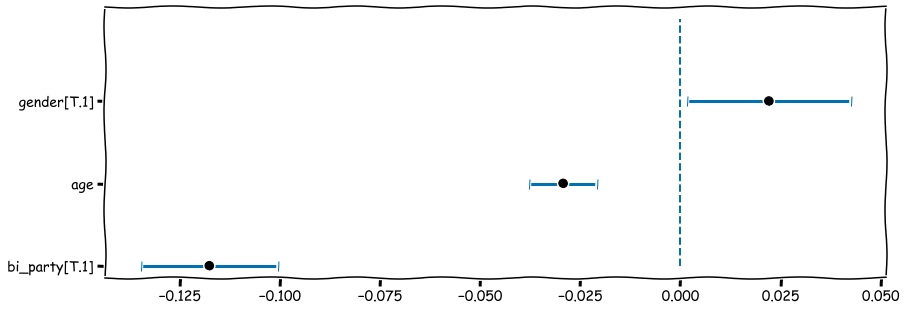

In [26]:
#fancy plotting
with plt.xkcd():
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 3,
                 linestyle = 'none',marker = 'o',markersize= 8,
                 markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1), linestyle = '--')

    plt.yticks(range(len(l2)),l2);
    plt.savefig('nb_errorbar.svg')

### Interpretation:
We can state that
- Age and the political side are significant negative predictors of colloquialism use
- In a lesser extent gender is a  positive predictors of colloquialism use

Since all predictors are standardized, we can interpret in the following way:
- When all other predictors take mean values, an increase of age by 1 standard deviation (12 year), leads on average to a decrease by 0.0286 of log odds of colloquialism use.



In [27]:
mod_nb = smf.logit(formula='colloquial_NaiveBayes ~  age + bi_party + gender', data=df_reg_train)
res_nb = mod_nb.fit()
print(res_nb.summary())

Optimization terminated successfully.
         Current function value: 0.690777
         Iterations 4
                             Logit Regression Results                            
Dep. Variable:     colloquial_NaiveBayes   No. Observations:               460815
Model:                             Logit   Df Residuals:                   460811
Method:                              MLE   Df Model:                            3
Date:                   Thu, 16 Dec 2021   Pseudo R-squ.:               0.0005349
Time:                           08:24:48   Log-Likelihood:            -3.1832e+05
converged:                          True   LL-Null:                   -3.1849e+05
Covariance Type:               nonrobust   LLR p-value:                 1.516e-73
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2453      0.007     34.029      0.000       0.231       0.

In [28]:
# feature names
variables_nb = res_nb.params.index

# quantifying uncertainty!

# coefficients
coefficients_nb = res_nb.params.values

# p-values
p_values_nb = res.pvalues

# standard errors
standard_errors_nb = res_nb.bse.values

#confidence intervals
res_nb.conf_int()

,0,1
Intercept,0.231193,0.259454
bi_party[T.1],-0.081184,-0.057762
gender[T.1],-0.123450,-0.095665
age,0.003628,0.015213


In [29]:
#sort them all by coefficients
l1_nb, l2_nb, l3_nb, l4_nb = zip(*sorted(zip(coefficients_nb[1:], variables_nb[1:], standard_errors_nb[1:], p_values_nb[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)


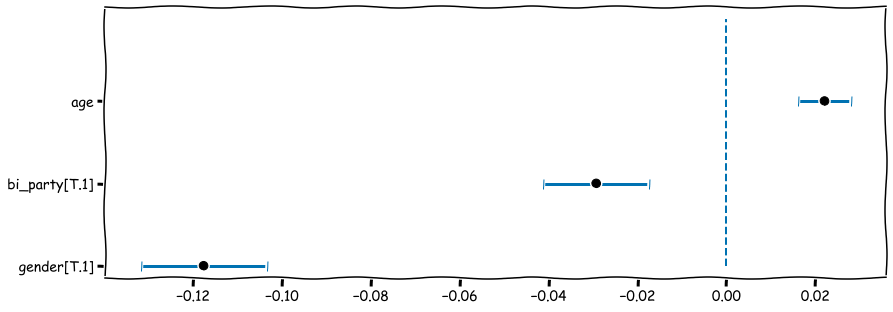

In [30]:
#fancy plotting
with plt.xkcd():
    plt.errorbar(l1, np.array(range(len(l1_nb))), xerr= 2*np.array(l3_nb), linewidth = 3,
                 linestyle = 'none',marker = 'o',markersize= 8,
                 markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1_nb), linestyle = '--')

    plt.yticks(range(len(l2_nb)),l2_nb);
    plt.savefig('nb_errorbar.svg')

### Interpretation:
We can state that
- Gender and the political side are significant negative predictors of colloquialism use
- In a lesser extent age is a significative positive predictors of colloquialism use

Since all predictors are standardized, we can interpret in the following way:
- When all other predictors take mean values, an increase of age by 1 standard deviation (12 year), leads on average to a increase by 0.088 of log odds of colloquialism use.

In [34]:
import scipy.stats as stats
print(stats.pearsonr(df_reg_train["bi_party"].values, df_reg_train["gender"]))
print(stats.pearsonr(df_reg_train["bi_party"].values, df_reg_train["age"]))
print(stats.pearsonr(df_reg_train["age"].values, df_reg_train["gender"]))


(-0.14552433859699482, 0.0)
(-0.04124688654482665, 1.1731269216831631e-172)
(0.019334236718007235, 2.339247941790642e-39)


Notice that the political orientation is significantly correlated with gender, that is, the older you are, the more chance you will be in the republican party.

## Interpretation of log-odds

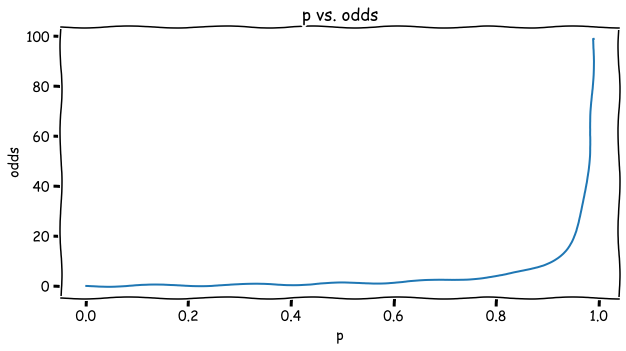

In [13]:
with plt.xkcd():  
    fig, axs = plt.subplots(1, 1, figsize=(10,5))
    p = np.linspace(0.001, 0.99, 999)
    odds = p/(1-p)
    axs.set_title("p vs. odds")
    axs.plot(p, odds)
    axs.set_xlabel("p")
    axs.set_ylabel("odds")
    
    plt.savefig('log_ods1.svg')

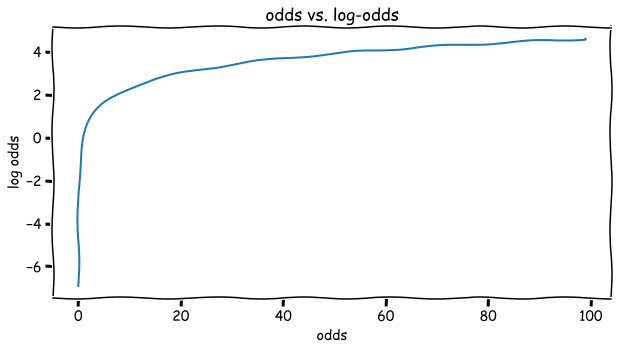

In [14]:
with plt.xkcd():  
    fig, axs = plt.subplots(1, 1, figsize=(10,5))
    axs.set_title("odds vs. log-odds")
    axs.plot(odds, np.log(odds))
    axs.set_xlabel("odds")
    axs.set_ylabel("log odds")
    plt.savefig('log_ods2.svg')

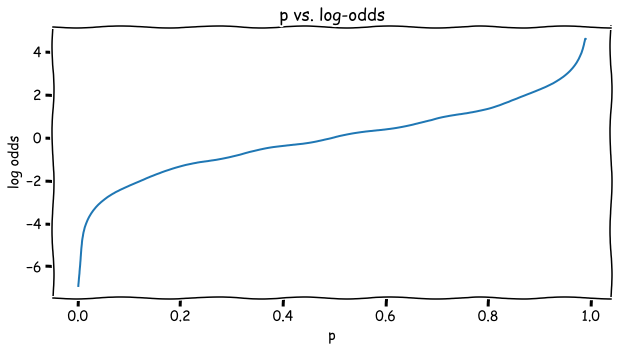

In [15]:
with plt.xkcd():  
    fig, axs = plt.subplots(1, 1, figsize=(10,5))
    axs.set_title("p vs. log-odds")
    axs.plot(p, np.log(odds))
    axs.set_xlabel("p")
    axs.set_ylabel("log odds")
    plt.savefig('log_ods3.svg')

In [33]:
df_pre_reg2.sample(56)

NameError: name 'df_pre_reg2' is not defined